In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.stats import randint, uniform

In [2]:
# Define helper functions for evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_model(y_true, y_pred, name="Model"):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }
    
    print(f"--- {name} Performance ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics


In [3]:
# Load the datasets
train_df = pd.read_csv('aggregated_data_train.csv')
test_df = pd.read_csv('aggregated_data_test.csv')

# drop the HH_ID column
train_df.drop('HH_ID', axis=1, inplace=True)
test_df.drop('HH_ID', axis=1, inplace=True)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Display basic statistics
train_df.info()

# Check for missing values
print("\nMissing values:")
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

Training data shape: (209396, 53)
Test data shape: (52350, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209396 entries, 0 to 209395
Data columns (total 53 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   Sector                                            209396 non-null  int64  
 1   State                                             209396 non-null  int64  
 2   NSS-Region                                        209396 non-null  int64  
 3   District                                          209396 non-null  int64  
 4   Household Type                                    209396 non-null  int64  
 5   Religion of the head of the household             209396 non-null  int64  
 6   Social Group of the head of the household         209396 non-null  int64  
 7   HH Size (For FDQ)                                 209396 non-null  int64  
 8   NCO_3D               

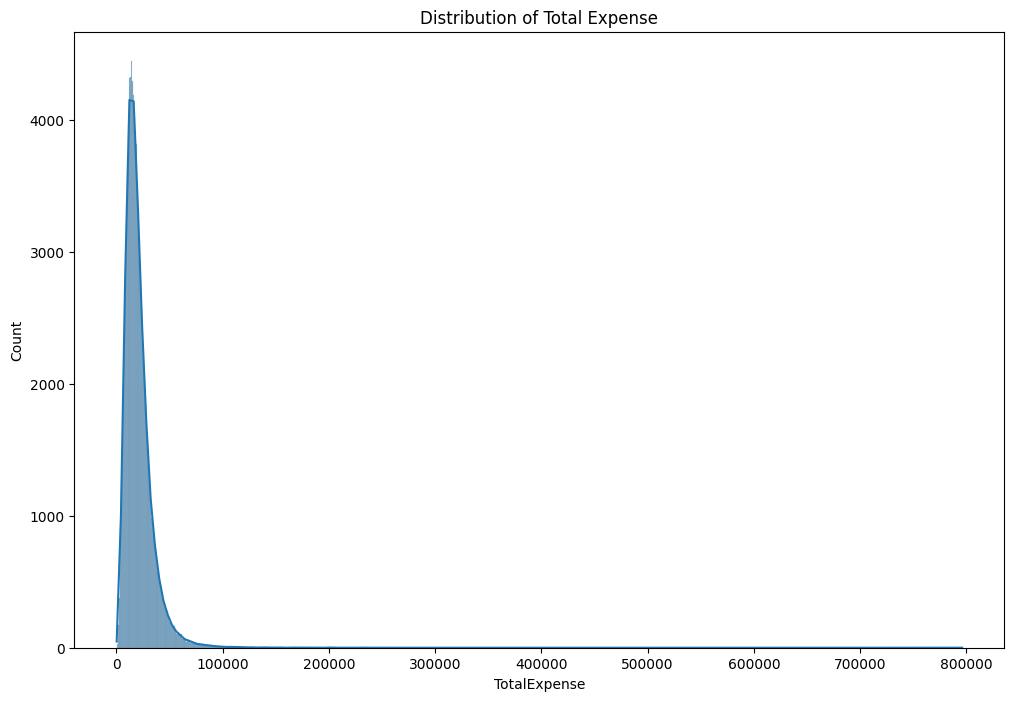

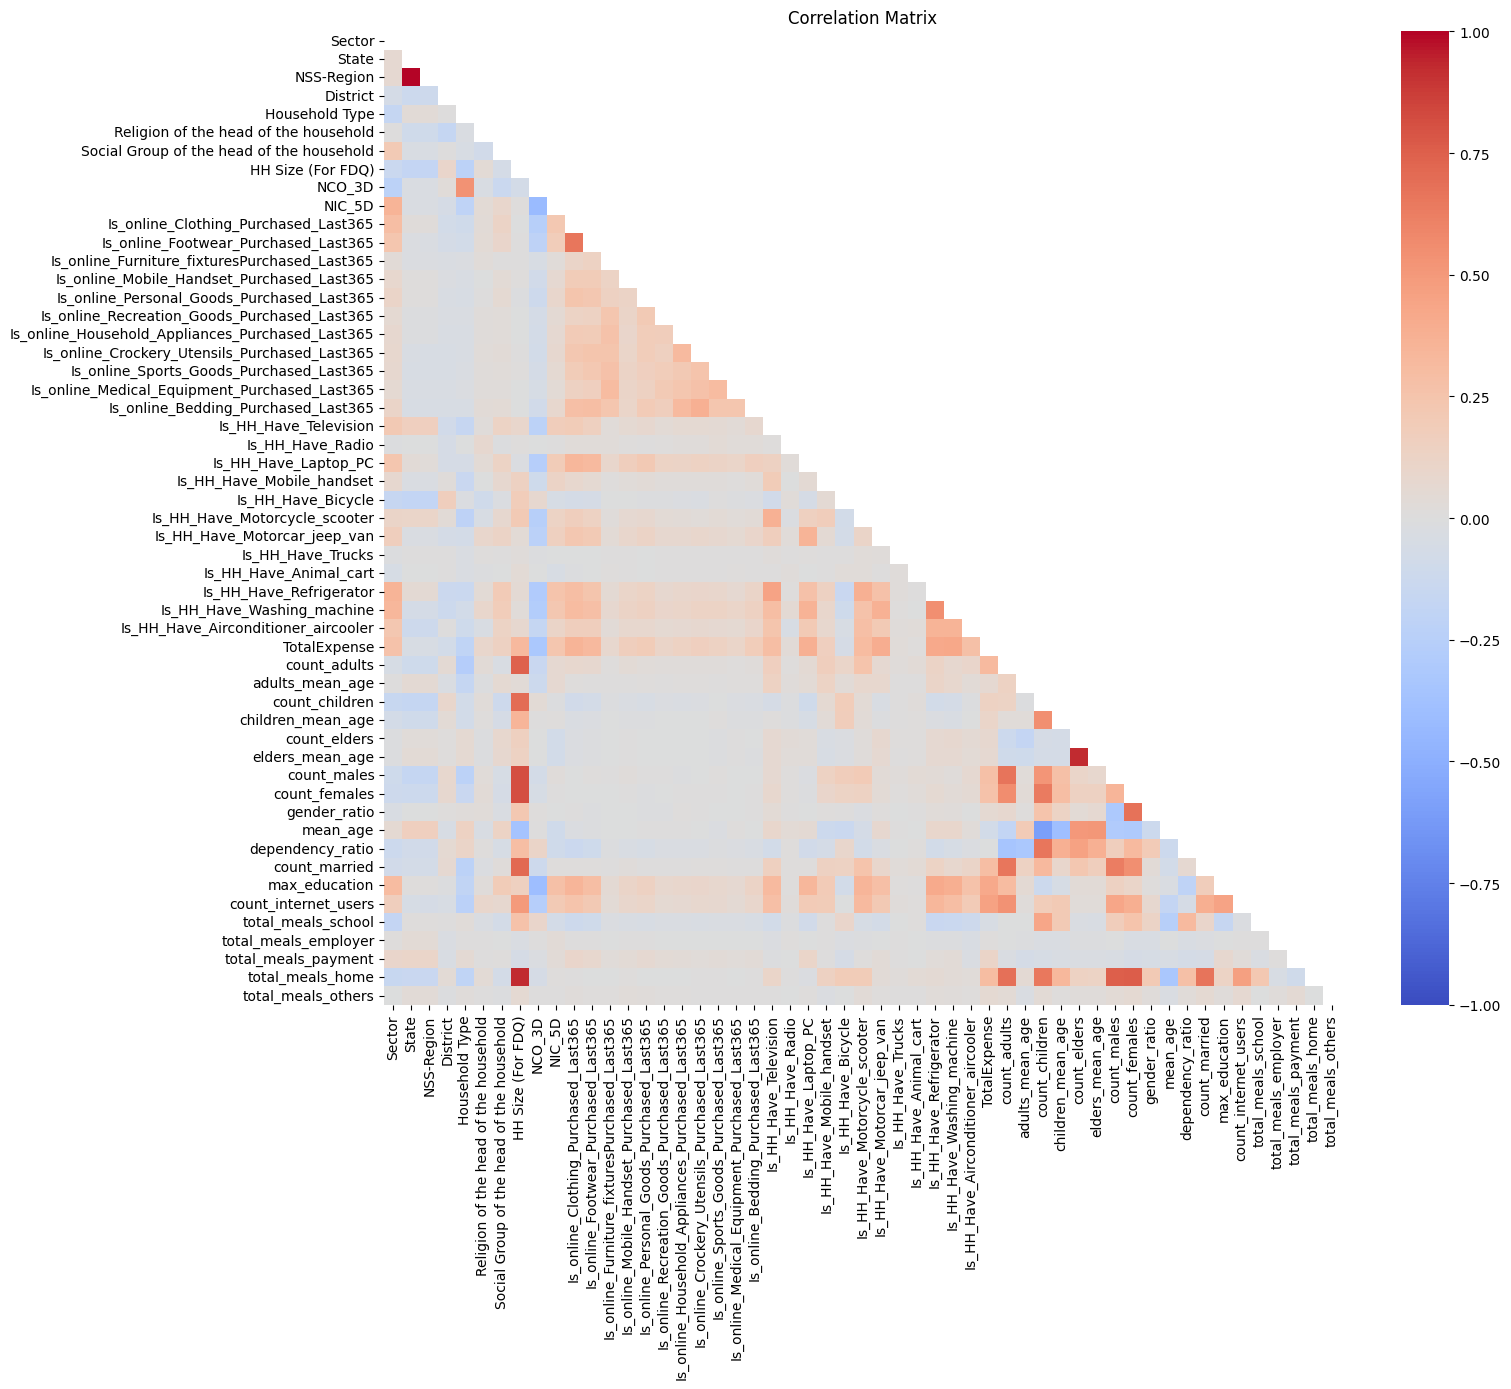

Top 10 correlated features with TotalExpense:
count_internet_users                    0.459426
Is_HH_Have_Washing_machine              0.426830
max_education                           0.419081
Is_HH_Have_Refrigerator                 0.416625
Is_HH_Have_Motorcar_jeep_van            0.394192
Is_HH_Have_Laptop_PC                    0.375434
Is_online_Clothing_Purchased_Last365    0.355702
HH Size (For FDQ)                       0.325764
Is_online_Footwear_Purchased_Last365    0.323600
count_adults                            0.312829
Name: TotalExpense, dtype: float64


In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 8))
sns.histplot(train_df['TotalExpense'], kde=True)
plt.title('Distribution of Total Expense')
plt.show()

# Correlation analysis
plt.figure(figsize=(16, 14))
corr_matrix = train_df.corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# Top correlated features with target
target_corr = corr_matrix['TotalExpense'].sort_values(ascending=False)
print("Top 10 correlated features with TotalExpense:")
print(target_corr[1:11])  # Skip the first one as it's the target correlation with itself

In [5]:
# Prepare data for modeling
X_train = train_df.drop('TotalExpense', axis=1)
y_train = train_df['TotalExpense']


# Split into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (167516, 52)
Validation data shape: (41880, 52)


In [8]:
# Baseline model
print("Training baseline Random Forest model...")
start_time = time.time()

baseline_rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
baseline_rf.fit(X_train_split, y_train_split)

# Evaluate baseline model
y_pred_val = baseline_rf.predict(X_val)
baseline_metrics = evaluate_model(y_val, y_pred_val, "Baseline Random Forest")
print(f"Training time: {time.time() - start_time:.2f} seconds")


Training baseline Random Forest model...
--- Baseline Random Forest Performance ---
MAE: 5519.3872
RMSE: 9851.2573
MAPE: 0.2898
R²: 0.5075
Training time: 90.30 seconds


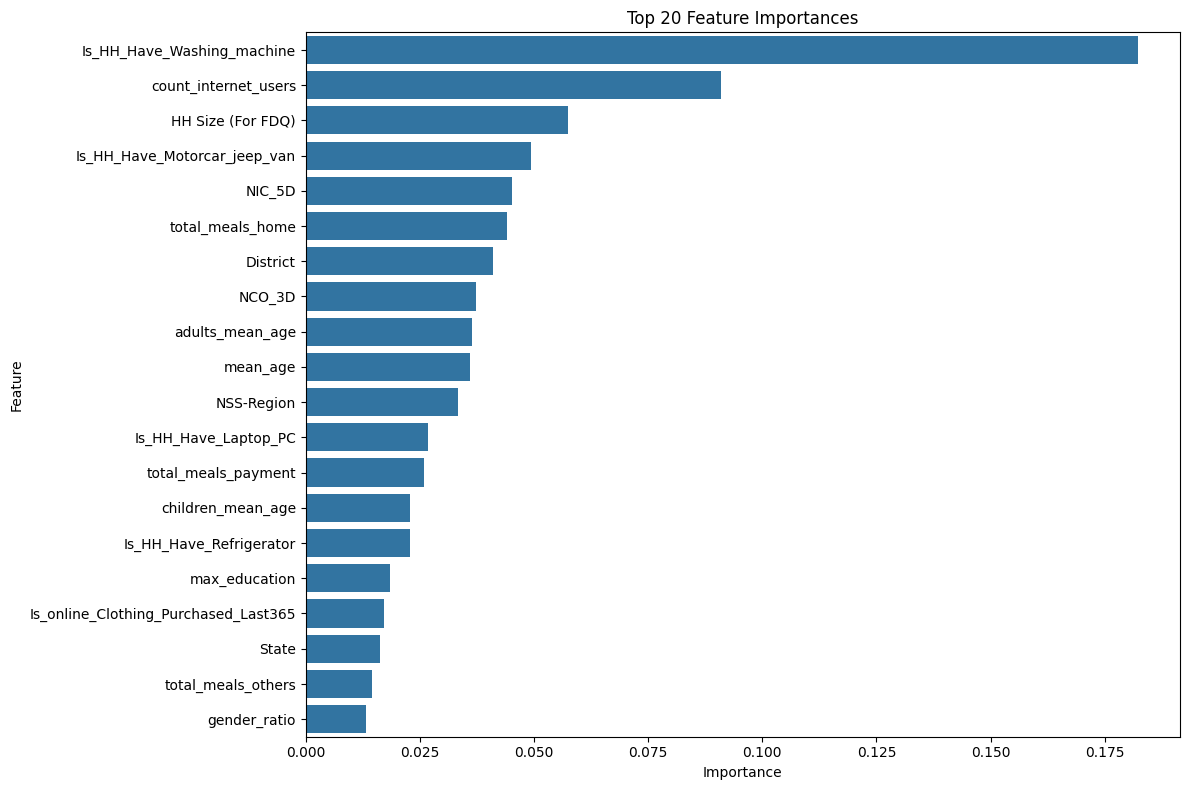

In [18]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': baseline_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter Tuning with RandomizedSearchCV
print("\nPerforming hyperparameter tuning with RandomizedSearchCV...")

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(randint(5, 30).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
start_time = time.time()
random_search.fit(X_train_split, y_train_split)
print(f"RandomizedSearchCV completed in {time.time() - start_time:.2f} seconds")

# Display best parameters
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

# Evaluate model with best parameters found by RandomizedSearchCV
best_random_rf = random_search.best_estimator_
y_pred_val_random = best_random_rf.predict(X_val)
random_search_metrics = evaluate_model(y_val, y_pred_val_random, "Tuned Random Forest (RandomizedSearchCV)")


Performing hyperparameter tuning with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


: 

: 

In [ ]:
# Fine-tuning with GridSearchCV based on RandomizedSearchCV results
print("\nFine-tuning with GridSearchCV...")

# Create a narrower parameter grid around the best parameters
best_params = random_search.best_params_
param_grid = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth'] - 2 if best_params['max_depth'] is not None and best_params['max_depth'] > 3 else best_params['max_depth'], 
                 best_params['max_depth'], 
                 best_params['max_depth'] + 2 if best_params['max_depth'] is not None else None],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 1), best_params['min_samples_split'], best_params['min_samples_split'] + 1],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, bootstrap=best_params['bootstrap']),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
start_time = time.time()
grid_search.fit(X_train_split, y_train_split)
print(f"GridSearchCV completed in {time.time() - start_time:.2f} seconds")

# Display best parameters from GridSearchCV
print("\nBest parameters after fine-tuning:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Evaluate model with best parameters found by GridSearchCV
best_grid_rf = grid_search.best_estimator_
y_pred_val_grid = best_grid_rf.predict(X_val)
grid_search_metrics = evaluate_model(y_val, y_pred_val_grid, "Tuned Random Forest (GridSearchCV)")

In [ ]:
# Feature importance of the best model
feature_importance_tuned = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_tuned.head(20))
plt.title('Top 20 Feature Importances (Tuned Model)')
plt.tight_layout()
plt.show()

In [ ]:
# Train final model on entire training data
print("\nTraining final model on entire training data...")
final_model = RandomForestRegressor(**grid_search.best_params_, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# Prepare test data
X_test = test_df.drop('TotalExpense', axis=1) if 'TotalExpense' in test_df.columns else test_df


# If the target column is in the test data, evaluate the model
if 'TotalExpense' in test_df.columns:
    y_test = test_df['TotalExpense']
    y_pred_test = final_model.predict(X_test)
    test_metrics = evaluate_model(y_test, y_pred_test, "Final Model (Test Set)")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values (Test Set)')
    plt.show()
    
    # Plot residuals
    residuals = y_test - y_pred_test
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

In [ ]:
# Compare all models
if 'TotalExpense' in test_df.columns:
    models = ['Baseline RF', 'RandomizedSearchCV RF', 'GridSearchCV RF']
    metrics_list = [baseline_metrics, random_search_metrics, grid_search_metrics]
    
    metrics_df = pd.DataFrame(metrics_list, index=models)
    
    # Plot comparison
    plt.figure(figsize=(14, 10))
    metrics_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Model Comparison')
    plt.ylabel('Value')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()
    
    print("\nModel Comparison:")
    print(metrics_df)

# Save the final model
import joblib
joblib.dump(final_model, 'random_forest_regression_model.pkl')
print("Final model saved as 'random_forest_regression_model.pkl'")